In [1]:
from functools import partial
import h5py as h5
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import joblib as jl
import torch as pt
from pytorch_lightning import Trainer
from precept import PreceptModule, PreceptDataFrameModule
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from hy.contrib.pprint import pp

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
device_type = "nmos"
tech        = "xh035"
data_path   = f"../data/{tech}-{device_type}.h5"

In [4]:
with h5.File(data_path, 'r') as db:
    col_names   = list(db.keys())
    data_matrix = np.transpose(np.array([db[c] for c in col_names]))
    data_raw    = pd.DataFrame(data_matrix, columns=col_names).dropna()

In [5]:
params_x = ["Vds", "Vgs", "Vbs", "W", "L"]
params_y = ["vth","vdsat","ron","gm","gmbs","gds","betaeff","id","gmoverid"
           ,"vearly","self_gain","rout","pwr","fug"] #,"cgs","cgd","cdb"
normed_y = ["ron","gm","gmbs","gds","betaeff","id","self_gain","rout","pwr"]

In [2]:
for ny in normed_y:
    data_raw[ny] = data_raw[ny] / data_raw["W"]

SyntaxError: invalid syntax (3045203417.py, line 1)

In [6]:
data_x = data_raw[params_x]
data_y = data_raw[params_y]

In [7]:
data_norm_x = pd.DataFrame(minmax_scale(data_x.values), columns=params_x)
data_norm_y = pd.DataFrame(minmax_scale(data_y.values), columns=params_y)

/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5, 1.0, 'Scaled Y Parameters')

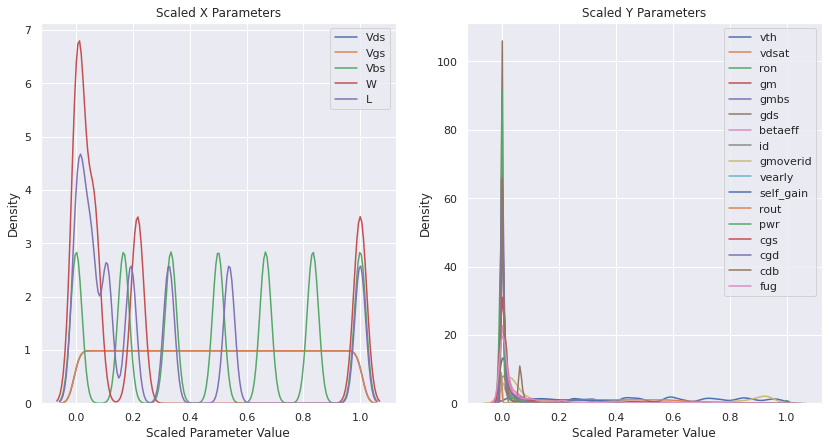

In [8]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,7), nrows=1, ncols=2)

for c in data_norm_x.columns.values:
    sns.kdeplot(data_norm_x[c], ax=ax1, label=c)

for c in data_norm_y.columns.values:
    sns.kdeplot(data_norm_y[c], ax=ax2, label=c)

ax1.set_xlabel("Scaled Parameter Value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Scaled X Parameters")
ax2.set_xlabel("Scaled Parameter Value")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Scaled Y Parameters")

In [9]:
params_t          = ["fug", "betaeff", "pwr", "gmbs", "gds", "gm", "vdsat", "ron", "rout", "id", "self_gain", "vearly"]
data_trafo        = data_raw[(params_x + params_y)].copy()

for t in params_t:
    data_trafo[t] = np.log10(np.abs(data_trafo[t].values), where=(data_trafo[t].values != 0))
    
data_scale        = pd.DataFrame(minmax_scale(data_trafo.values), columns=(params_x + params_y))

data_scale_x      = data_scale[params_x]
data_scale_y      = data_scale[params_y]

Text(0.5, 1.0, 'Transformed Y Parameters')

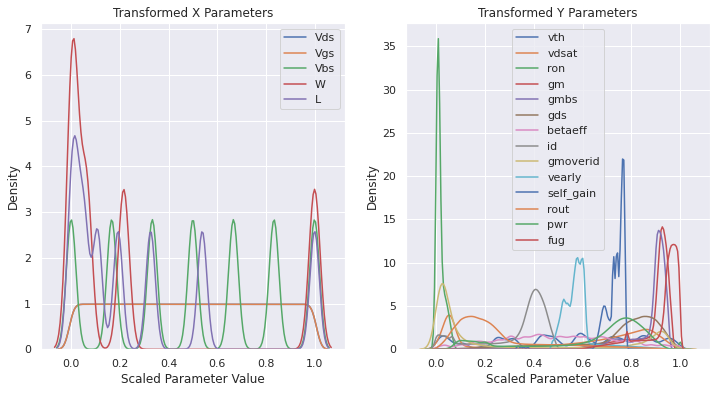

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

for c in data_scale_x.columns.values:
    sns.kdeplot(data_scale_x[c], ax=ax1, label=c)

for c in data_scale_y.columns.values:
    sns.kdeplot(data_scale_y[c], ax=ax2, label=c)

ax1.set_xlabel("Scaled Parameter Value")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Not-Transformed X Parameters")
ax2.set_xlabel("Scaled Parameter Value")
ax2.set_ylabel("Density")
ax2.legend()
ax2.set_title("Transformed Y Parameters")

In [11]:
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()

data_scale_x = scale_x.fit_transform(data_trafo[params_x].values)
data_scale_y = scale_y.fit_transform(data_trafo[params_y].values)

In [12]:
data_scale = pd.DataFrame( np.hstack((data_scale_x, data_scale_y))
                         , columns=(params_x + params_y))

In [13]:
model_dir    = f"../models/ifx/op"
model_prefix = f"{model_dir}/{tech}-{device_type}"

data = PreceptDataFrameModule( data_scale, params_x, params_y, [], [], [], []
                             , batch_size = 2000
                             , test_split = 0.2
                             , scale      = False
                             , )

module = PreceptModule( len(params_x), len(params_y)
                      , model_path = model_dir
                      , )

trainer = Trainer( gpus                = 1
                 , max_epochs          = 42
                 , precision           = 32
                 , checkpoint_callback = True
                 , default_root_dir    = model_dir
                 , )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
trainer.fit(module, data)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 M 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.528     Total estimated model params size (MB)


Epoch 0:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 503/629 [00:07<00:01, 68.51it/s, loss=0.00345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 504/629 [00:07<00:01, 68.99it/s, loss=0.0028, v_num=0, valid_loss=0.020]
Validating: 0it [00:00, ?it/s]
Epoch 2:  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 503/629 [00:07<00:01, 69.30it/s, loss=0.00294, v_num=0, valid_loss=0.0146]
Validating: 0it [00:00, ?it/s]
Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 503/629 [00:08<00:02, 62.81it/s, loss=0.00259, v_num=0, valid_loss=0.0145]
Validating: 0it [00:00, ?it/s]
Epoch 4:  80%|██████████████████████

In [15]:
trainer.save_checkpoint(f"{model_prefix}_model.ckpt")

best_path  = module.cb_checkpoint.best_model_path
model_ckpt = PreceptModule.load_from_checkpoint(best_path)

model_ckpt.cpu().eval().freeze()

model_ckpt.to_torchscript( method         ='trace'
                         , example_inputs = pt.rand(1, len(params_x))
                         , ).save(f'{model_prefix}-model.pt')

jl.dump(scale_x, f'{model_prefix}-scale.X')
jl.dump(scale_y, f'{model_prefix}-scale.Y')

/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../models/ifx/op exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  if hasattr(mod, name):
/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):


['../models/ifx/op/xh035-nmos-scale.Y']

In [37]:
class PrimitiveDevice:
    def __init__(self, prefix: str, px=params_x, py=params_y):
        self.params_x = px
        self.params_y = py
        self.pty      = [ "fug", "betaeff", "pwr", "gmbs", "gds", "gm", "vdsat"
                        , "ron", "rout", "id", "self_gain", "vearly"]
        self.model    = pt.jit.load(f'{prefix}-model.pt').cpu().eval()
        self.scale_x  = jl.load(f'{prefix}-scale.X')
        self.scale_y  = jl.load(f'{prefix}-scale.Y')
    
    def _predict(self, X: np.array) -> np.array:
        with pt.no_grad():
            Y = self.scale_y.inverse_transform(self.model(pt.from_numpy(np.float32(self.scale_x.transform(X)))).numpy())
        return Y 
                
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        #for t in self.ptx:
        #    X[t] = np.log10(np.abs(X[t].values), where=(X[t].values != 0))
                           
        Y = pd.DataFrame( self._predict(X[self.params_x].values)
                        , columns=self.params_y)
                           
        for t in self.pty:
            Y[t] = np.power(10, Y[t].values)

        return Y

In [38]:
nmos = PrimitiveDevice(model_prefix)

In [51]:
tru_data  = data_raw.sample(frac=1)
tru_x     = tru_data[params_x]
tru_y     = tru_data[params_y]

In [52]:
prd_y = nmos.predict(tru_x)

/tmp/ipykernel_1077036/2828881761.py:24: RuntimeWarning: overflow encountered in power
  Y[t] = np.power(10, Y[t].values)


In [53]:
loss = tru_y.sub(prd_y).div(tru_y)
loss = loss[~loss.isin([np.nan, np.inf, -np.inf]).any(1)]
loss.describe()

,vth,vdsat,ron,gm,gmbs,gds,betaeff,id,gmoverid,vearly,self_gain,rout,pwr,cgs,cgd,cdb,fug
count,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06,1.219663e+06
mean,-4.900701e-02,-4.533296e+00,-2.197317e+18,-1.129549e+41,-1.310901e+41,-3.180211e+19,-3.779807e+01,-1.160109e+11,-6.743596e+00,-1.782773e+11,-5.095290e+26,-1.922066e+19,-4.844523e+10,9.160305e-01,7.923448e-01,7.351074e-01,-2.887633e+40
std,3.288968e-01,1.030568e+01,1.937346e+20,9.277113e+43,1.020196e+44,7.308760e+21,2.269422e+02,1.804492e+12,1.764964e+01,2.168877e+13,3.546162e+29,3.766666e+21,8.954364e+11,2.184763e-01,3.179621e-01,3.110178e-01,2.771255e+43
min,-1.149076e+00,-7.023948e+01,-9.624693e+22,-9.194176e+46,-8.370606e+46,-5.643626e+24,-8.457604e+03,-1.444337e+14,-3.998775e+02,-1.398751e+16,-3.142775e+32,-3.106594e+24,-1.567633e+14,2.563172e-05,1.891556e-08,3.703688e-08,-3.019542e+46
25%,-2.338394e-01,-2.735991e+00,-3.733614e+02,-8.806457e+01,-9.147349e+01,-1.428572e+03,-7.130612e+00,-2.241721e+02,-3.840289e+00,-2.348379e+01,-1.371110e+01,-1.310575e+03,-3.074815e+02,9.543661e-01,7.472177e-01,6.156434e-01,-7.040360e+01
50%,1.873359e-04,-1.004494e-03,-3.662513e-01,3.262145e-02,6.081197e-03,-3.018491e-02,6.568413e-03,-4.102667e-02,3.380578e-03,1.578410e-02,3.458553e-02,3.066406e-02,-2.878472e-02,9.935118e-01,9.358086e-01,8.730099e-01,-1.466420e-02
75%,1.895885e-01,7.286004e-01,9.952778e-01,9.892464e-01,9.891513e-01,9.992426e-01,8.786186e-01,9.951575e-01,7.997617e-01,9.609314e-01,9.359810e-01,9.993049e-01,9.965555e-01,9.988285e-01,9.944956e-01,9.640640e-01,9.855276e-01
max,5.348827e-01,9.859421e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.998806e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999987e-01,1.000000e+00,1.000000e+00,9.999660e-01,9.999528e-01,9.993477e-01,1.000000e+00


In [1]:
(setv trace-tru (.sort-values (get data-raw (& (= data-raw.Vds 1.65)
                                               (= data-raw.Vbs 0.0)
                                               (= data-raw.W (np.random.choice (.unique data-raw.W)))
                                               (= data-raw.L (np.random.choice (.unique data-raw.L)))))
                              :by ["gmoverid"]))

(setv device-prefix f"./models/{tech}-{device-type}-{time-stamp}/{tech}-{device-type}"
      device (PrimitiveDevice device-prefix))

(setv trace-prd (device.predict (.copy trace-tru)))

(setv (, fig (, ax1 ax2)) (plt.subplots 2 1 :sharey False))
(ax1.plot trace-tru.gmoverid trace-tru.idoverw :label f"Truth")
(ax1.plot trace-tru.gmoverid trace-prd.idoverw :label f"Prediction")
(ax1.grid)
(ax1.set-yscale "log")
(ax1.set-xlabel "gm/Id [1/V]")
(ax1.set-ylabel "Id/W [A/m]")
(ax1.legend)
(ax2.plot trace-tru.gmoverid trace-tru.gdsoverw :label f"Truth")
(ax2.plot trace-tru.gmoverid trace-prd.gdsoverw :label f"Prediction")
(ax2.grid)
(ax2.set-xlabel "gm/Id [1/V]")
(ax2.set-ylabel "gds/W [S/m]")
(ax2.legend)
(plt.show)


SyntaxError: invalid syntax (3521712929.py, line 1)